# [Sutton and Barto Notebooks](https://github.com/seungjaeryanlee/sutton-barto-notebooks): Example 6.6

[모두AI](https://www.modu.ai)  
Author: Ryan Lee  
저자: 이승재  

![Example 6.6](example_6_6.png)

In [1]:
import copy
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def argmax_all(list_):
    """
    Returns all argmax of given list in a list. Different from np.argmax which 
    returns first instance only.
    주어진 list의 최대값들의 index들을 list 형태로 반환합니다. 첫 최대값의 index만 반환하는
    np.argmax와는 다릅니다.
    """
    return np.argwhere(list_ == list_.max()).flatten()

In [3]:
class Action(IntEnum):
    """
    Enum of possible actions in the Cliff environment.
    절벽 환경에서 가능한 행동들을 나타내는 enum.
    """
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

## Environment

In [4]:
class Environment:
    """
    The Cliff environment shown in Example 6.6.
    Example 6.6의 절벽 환경입니다.
    """
    action_space = list(map(int, Action))

    def __init__(self, width=12, height=4):
        self.W = width
        self.H = height
        self.state_space = [i for i in range(width * height)]

        self.state = width * (height - 1)

    def _is_goal(self):
        """
        Checks if current state is the goal state.
        현재 상태가 목표 지점인지 확인합니다.
        """
        return self.state == self.W * self.H - 1

    def _is_cliff(self):
        """
        Checks if current state is a cliff.
        현재 상태가 절벽인지 확인합니다.
        """
        return self.state in range(self.W * (self.H - 1) + 1, self.W * self.H - 1)

    def reset(self):
        """
        Resets environment and returns initial state.
        환경을 초기화하고 초기화된 상태를 반환합니다.
        """
        self.state = self.W * (self.H - 1)
        return self.state
    
    def step(self, action):
        """
        Performs given action and returns next_state, reward, done.
        주어진 행동을 하고 다음 상태, 보상, 그리고 에피소드가 끝났는지를 반환합니다.
        """
        assert action in self.action_space

        if action == Action.LEFT:
            if self.state % self.W > 0:
                self.state -= 1
        elif action == Action.RIGHT:
            if self.state % self.W < self.W - 1:
                self.state += 1
        elif action == Action.UP:
            if self.state // self.W > 0:
                self.state -= self.W
        elif action == Action.DOWN:
            if self.state // self.W < self.H - 1:
                self.state += self.W

        if self._is_cliff():
            reward = -100
            self.state = self.W * (self.H - 1)
        else:
            reward = -1

        done = self._is_goal()

        return self.state, reward, done

In [5]:
class SarsaAgent:
    def __init__(self,
                 state_space,
                 action_space, 
                 epsilon=0.1,
                 learning_rate=0.1,
                 discount_factor=1):
        """
        Initialize Q table and save environment.
        Q 테이블을 초기화하고 주어진 환경을 보관합니다.
        """
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        self.q_table = np.zeros((len(state_space), len(action_space)), dtype=float)

    def get_action(self, state):
        """
        Returns action based on Q table and epsilon-greedy policy.
        엡실론 탐욕 정책과 Q테이블을 이용해 주어진 상태에서 할 행동을 반환합니다.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            best_actions = argmax_all(self.q_table[state])
            return np.random.choice(best_actions)

    def update_q(self, state, action, reward, next_state, done):
        """
        Update Q table via SARSA.
        SARSA를 통해 Q 테이블을 업데이트합니다.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * self.q_table[next_state][self.get_action(next_state)]

        self.q_table[state][action] = ((1 - self.learning_rate) * self.q_table[state][action]
                                    + self.learning_rate * target)

In [6]:
class QLearningAgent:
    def __init__(self,
                 state_space,
                 action_space, 
                 epsilon=0.1,
                 learning_rate=0.1,
                 discount_factor=1):
        """
        Initialize Q table and save environment.
        Q 테이블을 초기화하고 주어진 환경을 보관합니다.
        """
        self.state_space = state_space
        self.action_space = action_space
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        self.q_table = np.zeros((len(state_space), len(action_space)), dtype=float)

    def get_action(self, state):
        """
        Returns action based on Q table and epsilon-greedy policy.
        엡실론 탐욕 정책과 Q테이블을 이용해 주어진 상태에서 할 행동을 반환합니다.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            best_actions = argmax_all(self.q_table[state])
            return np.random.choice(best_actions)

    def update_q(self, state, action, reward, next_state, done):
        """
        Update Q table via Q-Learning.
        Q러닝을 통해 Q 테이블을 업데이트합니다.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * np.max(self.q_table[next_state])

        self.q_table[state][action] = ((1 - self.learning_rate) * self.q_table[state][action]
                                    + self.learning_rate * target)

## Plot

In [7]:
def run_episode(env, agent):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(1)
        next_state, reward, done = env.step(action)
        agent.update_q(state, action, reward, next_state, done)
        state = next_state

        total_reward += reward

    return total_reward

In [16]:
def plot(env, agents, n_episodes=500):
    names = []
    for name, agent in agents:
        names.append(name)
        total_rewards = np.zeros(n_episodes, dtype=float)
        for i in range(n_episodes):
            env.reset()
            total_rewards[i] = run_episode(env, agent)

        plt.plot(total_rewards)

    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.ylim(-100, -25)
    plt.legend(names)
    plt.show()

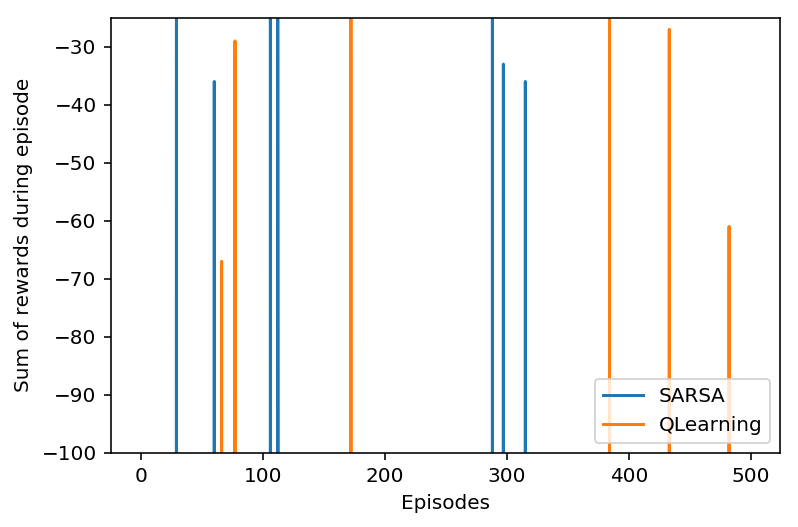

In [17]:
env = Environment()
agents = [
    ('SARSA', SarsaAgent(env.state_space, env.action_space)),
    ('QLearning', QLearningAgent(env.state_space, env.action_space)),
]
# plot(env, agents)

In [25]:
env = Environment()
agent = SarsaAgent(env.state_space, env.action_space)

for _ in range(1000):
    run_episode(env, agent)

In [26]:
for h in range(env.H):
    for w in range(env.W):
        best_action = Action(np.argmax(agent.q_table[h * env.W + w]))
        if best_action == Action.RIGHT:
            print('R', end='')
        elif best_action == Action.LEFT:
            print('L', end='')
        elif best_action == Action.UP:
            print('U', end='')
        elif best_action == Action.DOWN:
            print('D', end='')
    print()

LRDUUUUUULLL
UUUUDLUDDDLD
UUUUUUUUUURD
UUUUUUUUUUUU
